# Stable Diffusion Inpainting: How to run inference on the endpoint you have created?

Importing relevant packages for querying endpoint and image visualization

In [11]:
import boto3
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import numpy as np
import json
import base64
from PIL import Image
from io import BytesIO

In [27]:
region = boto3.Session().region_name
# s3_bucket = f"jumpstart-cache-prod-{region}"
# key_prefix = "model-metadata/assets"
# s3 = boto3.client("s3")

# s3.download_file(s3_bucket, f"{key_prefix}/{input_img_file_name}", input_img_file_name)
# s3.download_file(s3_bucket, f"{key_prefix}/{input_img_mask}", input_img_mask)

In [28]:
input_img_file_name = "bertrand-gabioud.png"
input_img_mask = "bertrand-gabioud-mask.png"

In [29]:
HTML(f'<table><tr><td> <img src="{input_img_file_name}" style="height: 700px;"/> <figcaption>Input Image</figcaption>'
     '</td></tr></table>')

Input Image


In [30]:
HTML(f'<table><tr><td> <img src="{input_img_mask}" style="height: 700px;"/> <figcaption>Input Image</figcaption>'
     '</td></tr></table>')

Input Image


### Query endpoint

***
Next, we query the endpoint to inpaint an image with a different image using a prompt. You can put in any image and a mask matching the dimension of the original image. Furthermore, you can replace the masked part with any image guided by the prompt.
***

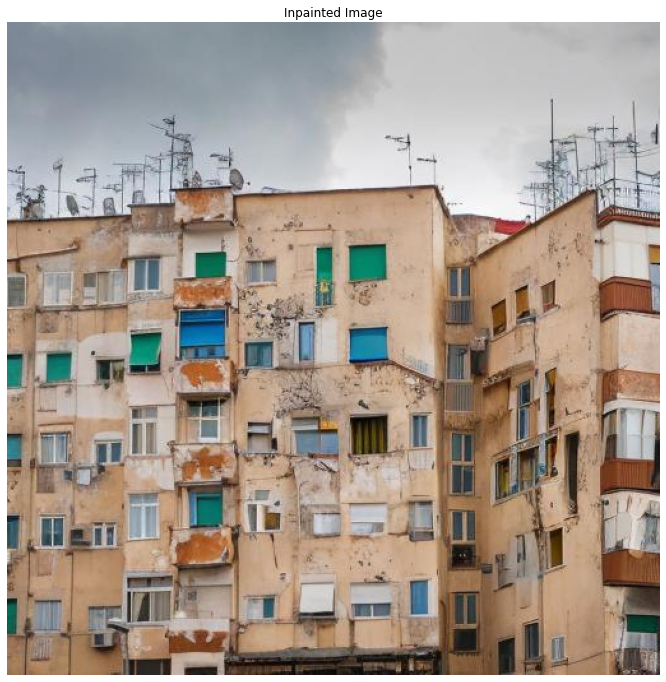

In [34]:
endpoint_name = 'jumpstart-dft-stable-diffusion-2-inpainting'

def encode_img(img_name):
    with open(img_name,'rb') as f: img_bytes = f.read()
    encoded_img = base64.b64encode(bytearray(img_bytes)).decode()
    return encoded_img

encoded_input_image = encode_img(input_img_file_name)
encoded_mask_image = encode_img(input_img_mask)


payload = { "prompt":"building, facade, paint, windows", "image": encoded_input_image, "mask_image":encoded_mask_image, "num_inference_steps":50, "guidance_scale":7.5, "seed": 1}

def query_endpoint(payload):
    """query the endpoint with the json payload encoded in utf-8 format."""
    encoded_payload = json.dumps(payload).encode('utf-8')
    client = boto3.client('runtime.sagemaker')
    # Accept = 'application/json;jpeg' returns the jpeg image as bytes encoded by base64.b64 encoding.
    # To receive raw image with rgb value set Accept = 'application/json'
    # To send raw image, you can set content_type = 'application/json' and encoded_image as np.array(PIL.Image.open('low_res_image.jpg')).tolist()
    # Note that sending or receiving payload with raw/rgb values may hit default limits for the input payload and the response size.
    response = client.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/json;jpeg', Accept = 'application/json;jpeg', Body=encoded_payload)
    return response

def display_image(img, title):
    plt.figure(figsize=(12,12))
    plt.imshow(np.array(img))
    plt.axis('off')
    plt.title(title)
    plt.show()

def parse_and_display_response(query_response):
    """Parse the endpoint response and display the generated images"""
    
    response_dict = json.loads(query_response['Body'].read())
    generated_images = response_dict['generated_images']
    
    for generated_image in generated_images:
        with BytesIO(base64.b64decode(generated_image.encode())) as generated_image_decoded:
            with Image.open(generated_image_decoded) as generated_image_np:
                generated_image_rgb = generated_image_np.convert("RGB")
                generated_image_rgb.save("inpainted-image.png")
                display_image(generated_image_rgb, "Inpainted Image")

query_response = query_endpoint(payload)
parse_and_display_response(query_response)

### Supported parameters

***
This model supports many parameters while performing inference. They include:

* **prompt**: prompt to guide the image generation. Must be specified and can be a string or a list of strings.
* **num_inference_steps**: number of denoising steps during image generation. More steps lead to higher quality image. If specified, it must a positive integer.
* **guidance_scale**: higher guidance scale results in image closely related to the prompt, at the expense of image quality. If specified, it must be a float. guidance_scale<=1 is ignored.
* **negative_prompt**: guide image generation against this prompt. If specified, it must be a string or a list of strings and used with guidance_scale. If guidance_scale is disabled, this is also disabled. Moreover, if prompt is a list of strings then negative_prompt must also be a list of strings.
* **num_images_per_prompt**: number of images returned per prompt. If specified it must be a positive integer.
* **seed**: fix the randomized state for reproducibility. If specified, it must be an integer.
* **batch_size**: Number of images to generate in a single forward pass. If using a smaller instance or generating many images, please reduce batch_size to be a small number (1-2). Number of images = number of prompts*num_images_per_prompt.

***

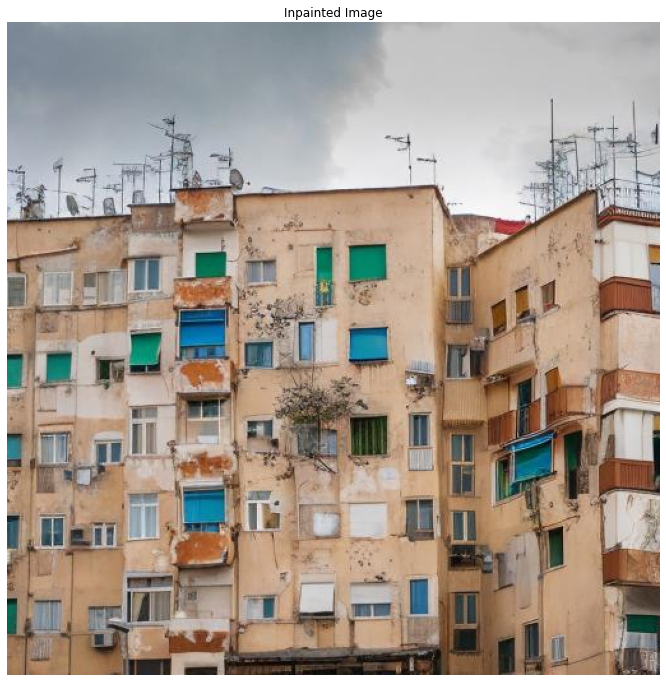

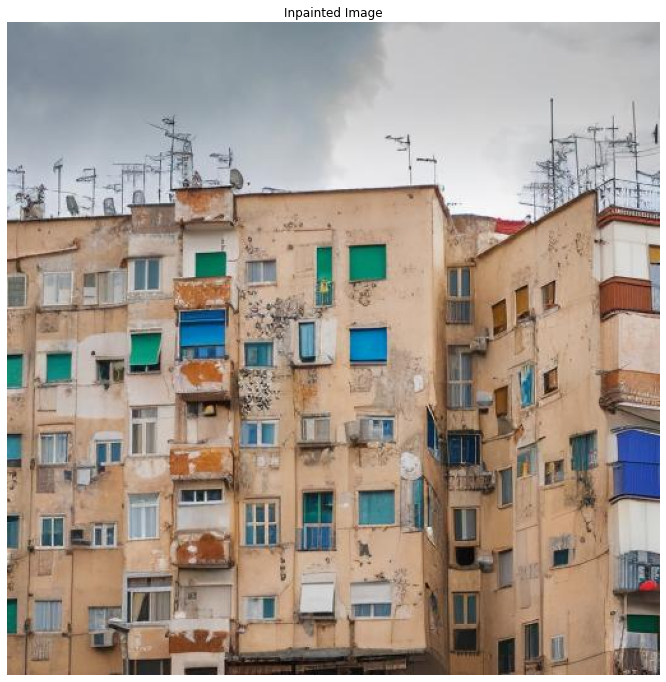

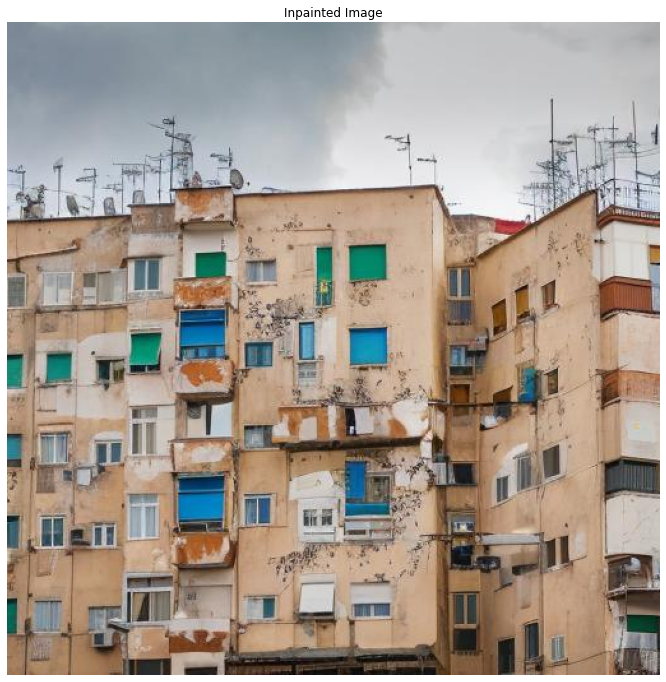

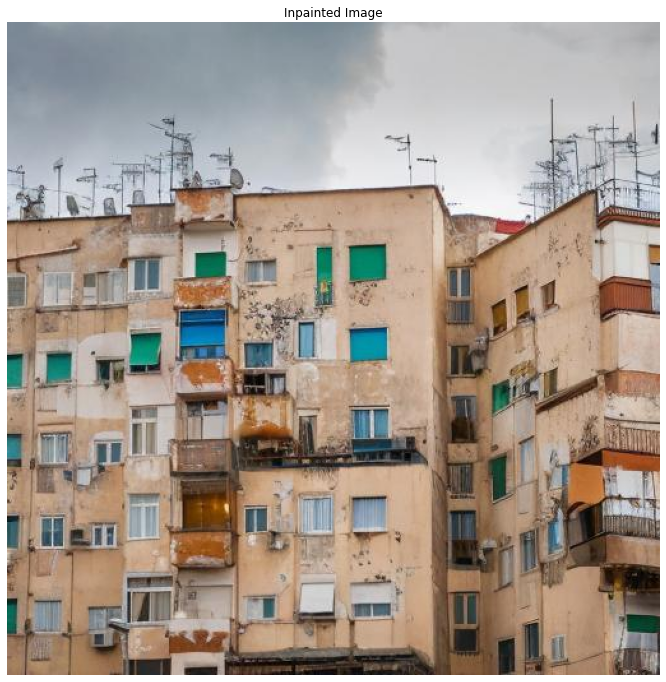

In [33]:
payload = { 
    "prompt":"a white cat, blue eyes, wearing a sweater, lying in park",
    "image":encoded_input_image, 
    "mask_image":encoded_mask_image, 
    "num_inference_steps":30,
    "guidance_scale":7.5,
    "num_images_per_prompt":4,
    "seed": 1,
    "negative_prompt": "poorly drawn feet",
    "batch_size":2
}
query_response = query_endpoint(payload)
parse_and_display_response(query_response)